In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

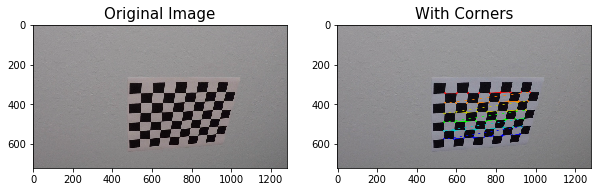

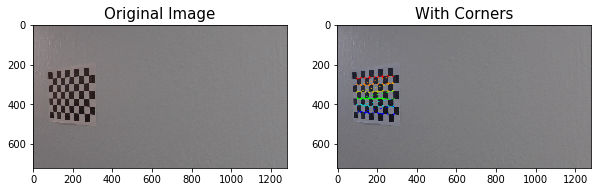

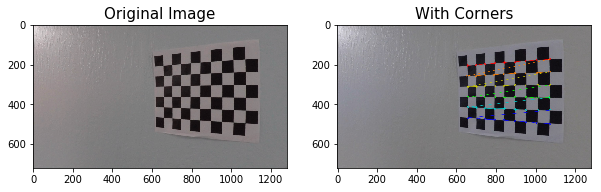

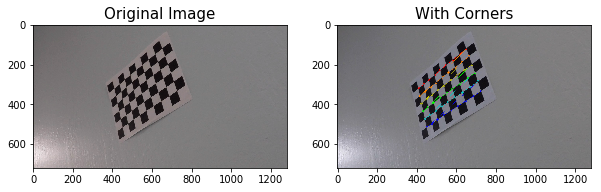

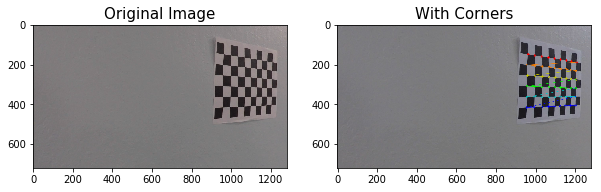

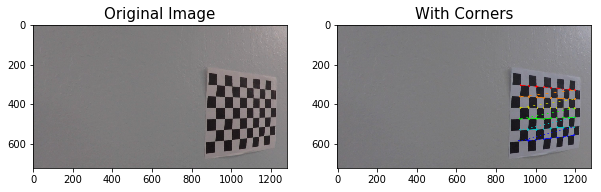

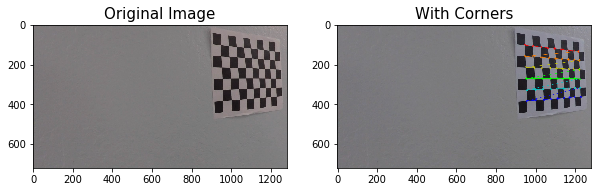

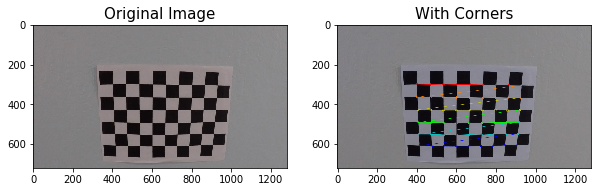

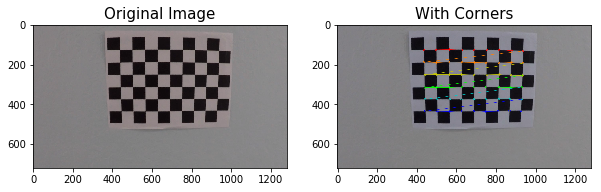

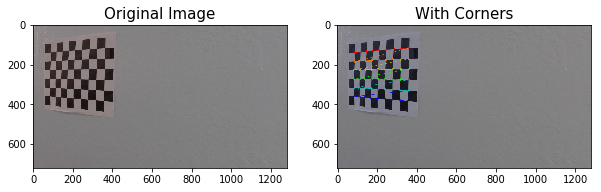

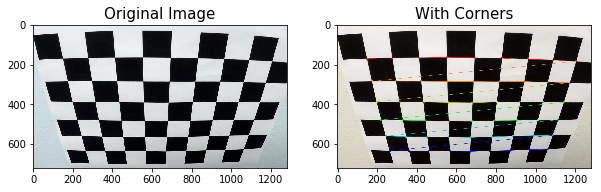

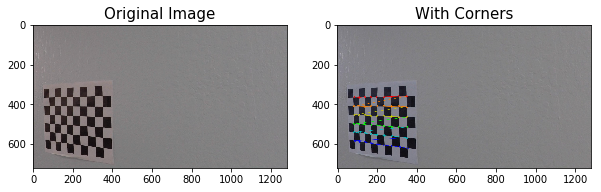

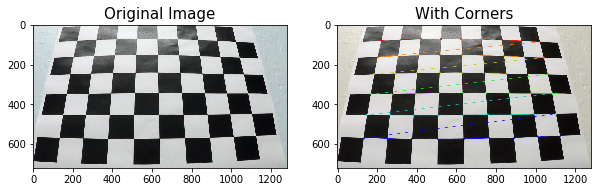

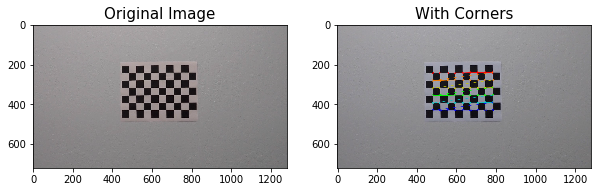

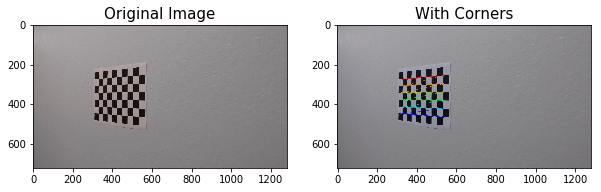

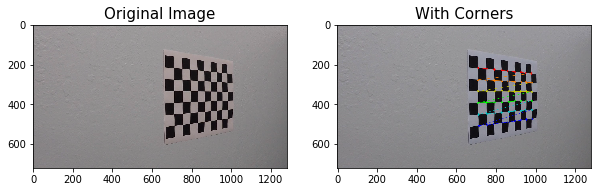

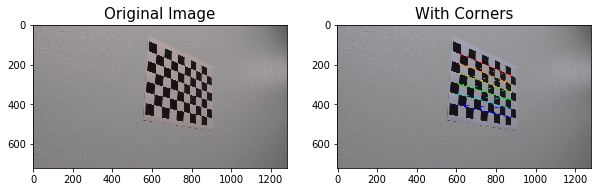

In [2]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Import, draw corners and display images
img_file_names = glob.glob('camera_cal/calibration*.jpg')
nx = 9
ny = 6

for fname in img_file_names:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=15)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=15)

In [3]:
# Remove distortion from images
def undistort(img, show=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    return undist

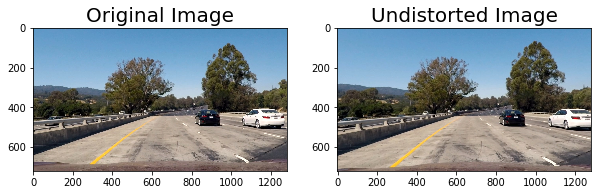

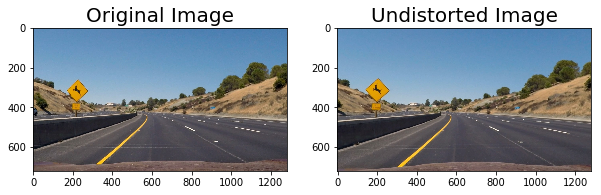

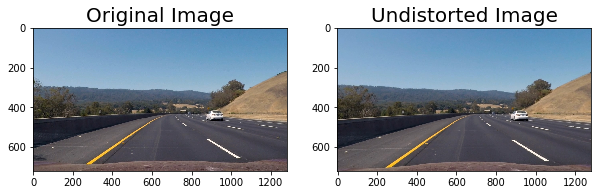

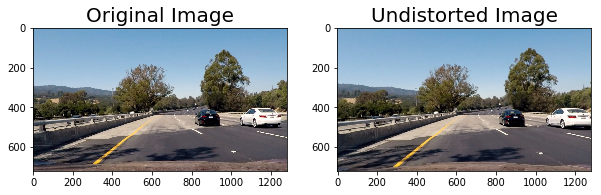

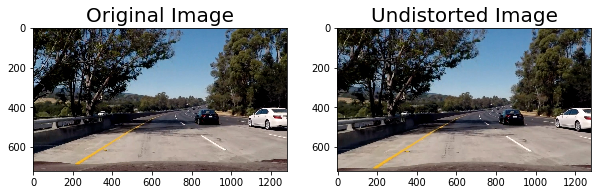

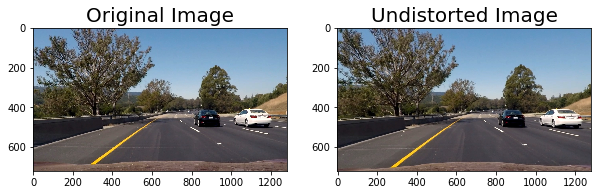

In [4]:
images = glob.glob('test_images/test[1-6].jpg')
for image in images:
    image = img = cv2.imread(image)
    undistort(image, True)

In [5]:
# Perform perspective transform
def persp_trans(undist_img, nx, ny, show=False):
    img_size = (undist_img.shape[1], undist_img.shape[0])
    offset = 0
    
    src = np.float32([[560, 475],[750, 475],
                      [1230, 720],[150, 720]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist_img, M, img_size)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return warped, M

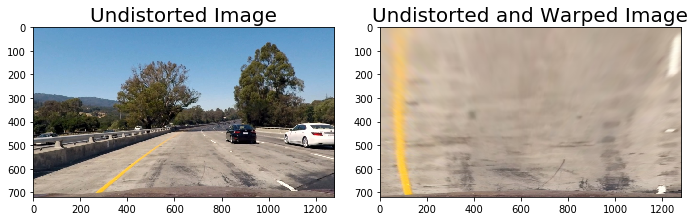

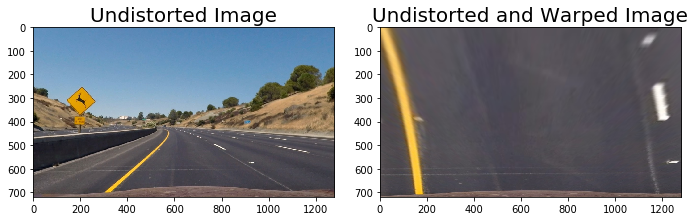

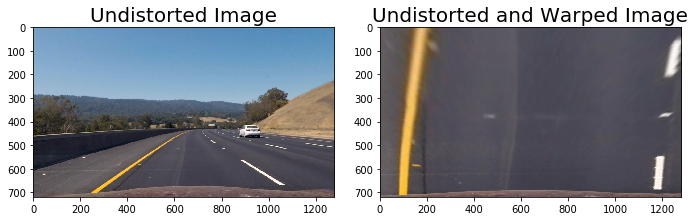

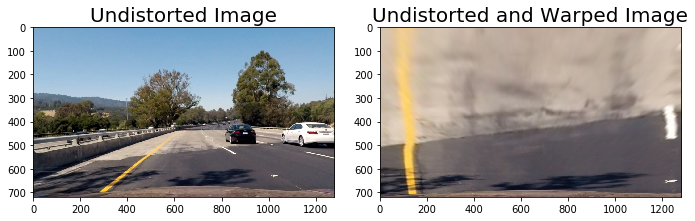

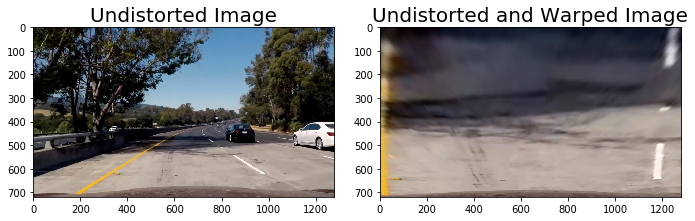

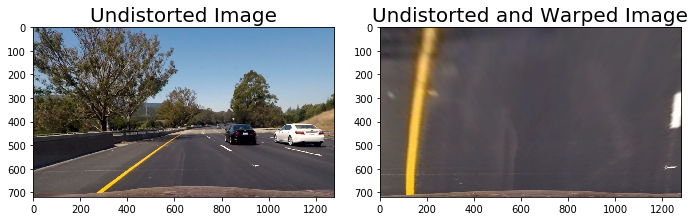

In [6]:
for img in glob.glob('test_images/test[1-6].jpg'):
    img = cv2.imread(img)
    undist_img = undistort(img)
    persp_trans(undist_img, nx, ny, show=True)

In [7]:
def abs_sobel(img, orient, sobel_kernel):
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    return abs_sobel

def scale(sobel):
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    return scaled_sobel

def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Calculate directional gradient
    sobel = abs_sobel(img, orient, sobel_kernel)
    # Scale sobel
    scaled_sobel = scale(sobel)
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_threshold(img, sobel_kernel, mag_thresh):
    # Take the gradient in x and y separately
    sobelx = abs_sobel(img, 'x', sobel_kernel)
    sobely = abs_sobel(img, 'y', sobel_kernel)
    # Calculate the magnitude
    sobel = np.sqrt(sobelx**2 + sobely**2)
    # Scale and convert to type int
    scaled_sobel = scale(sobel)
    # Create a binary mask
    sbinary = np.zeros_like(scaled_sobel)
    # Apply threshold
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary

def dir_threshold(img, sobel_kernel, dir_thresh):
    # Take the gradient in x and y separately
    sobelx = abs_sobel(img, 'x', sobel_kernel)
    sobely = abs_sobel(img, 'y', sobel_kernel)
    # Calculate the direction of gradient
    dir_grad = np.arctan2(sobely, sobelx)
    # Create a binary mask
    binary = np.zeros_like(dir_grad)
    # Apply threshold
    binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return binary

In [8]:
# Create binary thresholded images to isolate lane line pixels  
def detect_line(img, warped, show=False):
    s_channel = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)[:,:,2]
    #s_channel = cv2.cvtColor(warped, cv2.COLOR_BGR2HSV)[:,:,1]
    r_channel = warped[:,:,2]
    
    # S channel
    s_thresh_min = np.pi*0.45
    s_thresh_max = np.pi*0.55
    # Apply each of the thresholding functions
    s_gradx = abs_sobel_thresh(s_channel, 'x', 3, (15, 50))
    s_gradx = cv2.GaussianBlur(s_gradx, (7,7), 7)
    r_gradx = abs_sobel_thresh(cv2.GaussianBlur(r_channel, (7,7), 7), 'x', 3, (55, 60))
    blur_s_gradx = abs_sobel_thresh(cv2.GaussianBlur(s_channel, (15,15), 1), 'x', 3, (17, 50))
    scombined = np.zeros_like(s_gradx)
    scombined[(s_gradx == 1.) | (blur_s_gradx == 1.) | (r_gradx == 1.)] = 1
    
    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3, ax4,ax5, ax6)) = plt.subplots(1, 6, sharey='col', sharex='row', figsize=(20,2))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=7)
        ax1.imshow(cv2.cvtColor(undistort(img),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=7)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('S binary threshold', fontsize=7)
        ax3.imshow(s_gradx, cmap='gray')
        
        ax4.set_title('V binary threshold', fontsize=7)
        ax4.imshow(blur_s_gradx, cmap='gray')
        
        ax5.set_title('R binary threshold', fontsize=7)
        ax5.imshow(r_gradx, cmap='gray')

        ax6.set_title('Combined color thresholds', fontsize=7)
        ax6.imshow(scombined, cmap='gray')
    return scombined

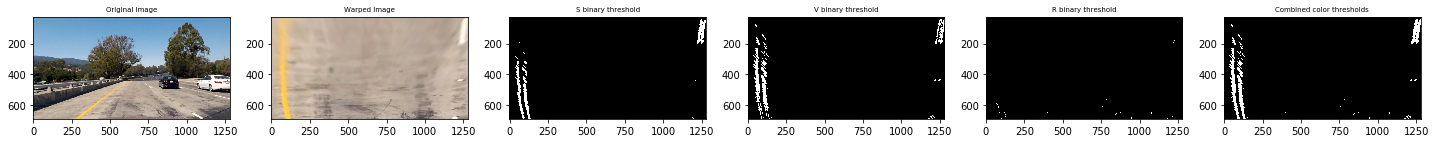

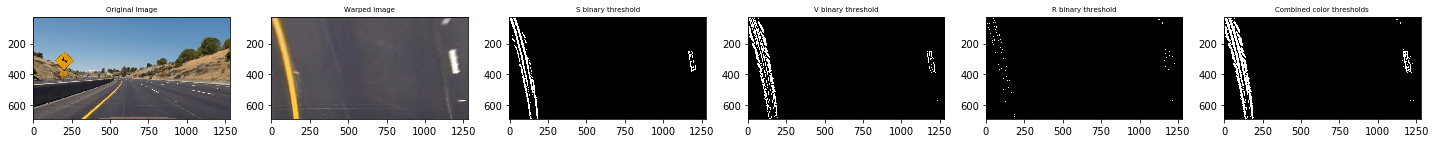

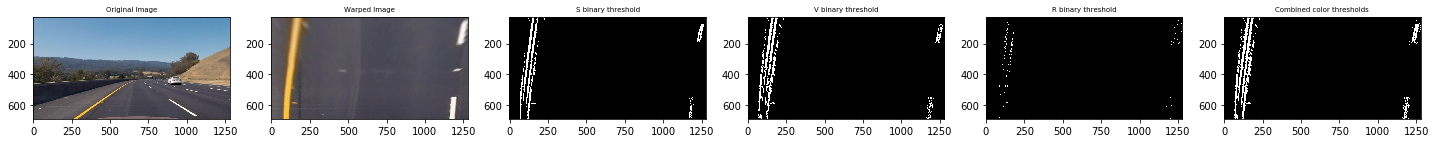

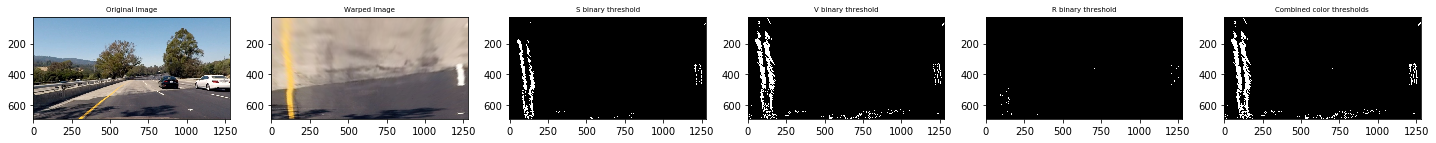

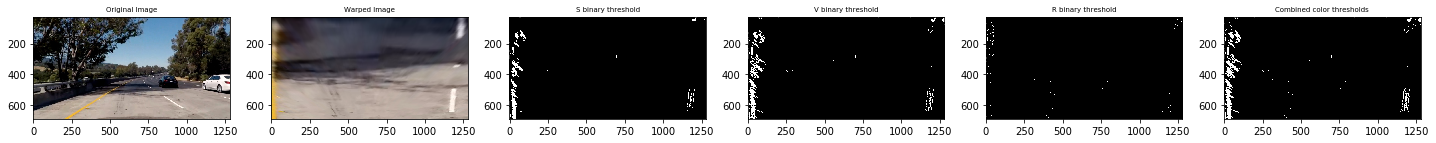

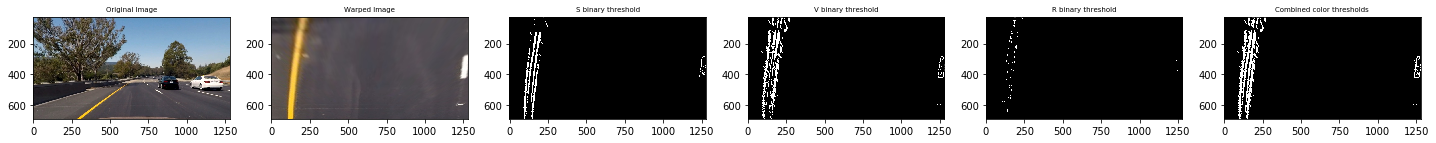

In [9]:
for img in glob.glob('test_images/test[1-6].jpg'):
    img = cv2.imread(img)
    undist_img = undistort(img)
    warped, M = persp_trans(undist_img, nx, ny)
    detect_line(img, warped, show=True)

In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.fit_cr = None 
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values of polynomial curvature
        self.fitx = None  
        # top point of polynomial curvature
        self.top = None
        # bottom point of polynomial curvature
        self.bottom = None
# Checking that they have similar curvature
# Checking that they are separated by approximately the right distance horizontally
# Checking that they are roughly parallel

In [24]:
def fill_lane(combined_binary, show=False):
    height, width = combined_binary.shape
    # Take a histogram of the bottom half of the image
    histogram = np.sum(combined_binary[height//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    mid_point = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:mid_point])
    rightx_base = np.argmax(histogram[mid_point:]) + mid_point
    
    # Choose the number of sliding windows
    nwindows = 18
    
    # Set height of windows
    window_height = np.int(height/nwindows)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set width of the windows +/- margin
    margin = 30
    # Set minimum number of pixels found to recenter window
    left_minpix = 70
    right_minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzerox = np.array(nonzero)[1]
    nonzeroy = np.array(nonzero)[0]
    for window in range(nwindows):
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_leftx_low = leftx_current - margin
        win_leftx_high = leftx_current + margin
        win_rightx_low = rightx_current - margin
        win_rightx_high = rightx_current + margin
        cv2.rectangle(out_img, (win_leftx_low,win_y_low), (win_leftx_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_rightx_low,win_y_low), (win_rightx_high,win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzerox >= win_leftx_low) & (nonzerox <= win_leftx_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_rightx_low) & (nonzerox <= win_rightx_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > left_minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > right_minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Generate values for plotting
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0])
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 12.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1000 # meters per pixel in x dimension
    
    # Extract left and right lane pixel positions
    if (np.count_nonzero(left_lane_inds) > 0):
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        # Color in left line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        # Sanity Check
        left_fit_bottom = left_fit_cr[2]
        left_fit_top = left_fit_cr[0]*(476*ym_per_pix)**2 + left_fit_cr[1]*(476*ym_per_pix) + left_fit_cr[2]
        if (0 < left_fit_bottom < 1.5) & (0 < left_fit_top < 1.5):
            # Calculate the new radii of curvature
            y_eval = np.max(ploty)
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            if (Left.radius_of_curvature != None):
                if (Left.radius_of_curvature*0.4 < left_curverad < Left.radius_of_curvature*2):
                    if (2.5 < (Right.bottom - left_fit_bottom) < 4.5):
                        Left.radius_of_curvature = left_curverad
                        Left.fitx = left_fitx
                        Left.recent_xfitted = left_lane_inds
                        Left.top = left_fit_top
                        Left.bottom = left_fit_bottom
                        Left.out_img = out_img
                        Left.fit_cr = left_fit_cr
                        Left.detected = True
                    else:
                        Left.detected = False
                else:
                    Left.detected = False
            else:
                # Calculate points between the left lane polynomial fit
                Left.radius_of_curvature = left_curverad
                Left.fitx = left_fitx
                Left.recent_xfitted = left_lane_inds
                Left.top = left_fit_top
                Left.bottom = left_fit_bottom
                Left.out_img = out_img
                Left.fit_cr = left_fit_cr
                Left.detected = True
        else:
            Left.detected = False
    else:
        Left.detected = False
    
    if (np.count_nonzero(right_lane_inds) > 0):
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Color in right line pixels
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Fit new polynomials to x,y in world space
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Sanity Check
        right_fit_bottom = right_fit_cr[2]
        right_fit_top = right_fit_cr[0]*(476*ym_per_pix)**2 + right_fit_cr[1]*(476*ym_per_pix) + right_fit_cr[2]
        if (2.5 < right_fit_bottom < 6) & (2.5 < right_fit_top < 6):
            # Calculate the new radii of curvature
            y_eval = np.max(ploty)
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            if (Right.radius_of_curvature != None):
                if (Right.radius_of_curvature*0.4 < right_curverad < Right.radius_of_curvature*2):
                    if (2.5 < (right_fit_bottom - left_fit_bottom) < 4.5):
                        Right.radius_of_curvature = right_curverad
                        Right.fitx = right_fitx
                        Right.recent_xfitted = right_lane_inds
                        Right.top = right_fit_top
                        Right.bottom = right_fit_bottom
                        Right.out_img = out_img
                        Right.fit_cr = right_fit_cr
                        Right.detected = True
                    else:
                        Right.detected = False
                else:
                    Right.detected = False
            else:
                # Calculate points between the left and right lane polynomial fit
                Right.radius_of_curvature = right_curverad
                Right.fitx = right_fitx
                Right.recent_xfitted = right_lane_inds
                Right.top = right_fit_top
                Right.bottom = right_fit_bottom
                Right.out_img = out_img
                Right.fit_cr = right_fit_cr
                Right.detected = True

        else:
            Right.detected = False
    else:
        Right.detected = False
    
    if Left.detected != True:
        if (Left.bottom != None) & (Left.top != None):
            left_fit_bottom = Left.bottom
            left_fit_top = Left.top
            left_fit_cr = Left.fit_cr
            left_fitx = Left.fitx
        # Draw the lane onto the warped blank image
        #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        
        
    if Right.detected != True:
        if (Right.bottom != None) & (Right.top != None):
            right_fit_bottom = Right.bottom
            right_fit_top = Right.top
            right_fit_cr = Right.fit_cr
            right_fitx = Right.fitx
        # Draw the lane onto the warped blank image
        #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))

    # Calculate distance between center
    ideal_center = (left_fit_bottom + right_fit_bottom)/2
    actual_center = width/2 * xm_per_pix
    Right.line_base_pos = right_fit_bottom - actual_center
    Left.line_base_pos = left_fit_bottom - actual_center
    
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    distance_from_center = abs(ideal_center - actual_center)
    curvature = int(left_curverad + right_curverad)/2
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot up the data
    if show == True:
        
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        f.tight_layout()    
        ax1.imshow(cv2.cvtColor((persp_trans(undistort(image), nx, ny)[0]), cv2.COLOR_BGR2RGB))
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(720, 0)
        ax1.plot(left_fitx, ploty, color='yellow', linewidth=3)
        ax1.plot(right_fitx, ploty, color='yellow', linewidth=3)
        ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
        ax2.imshow(result)
        ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
        ax2.text(200, 100, 'Distance from center: {:.2f}m'.format(distance_from_center),
                 style='italic', color='white', fontsize=10, position=(450,300))
        ax2.text(200, 175, 'Radius of curvature: {}m'.format(curvature),
                 style='italic', color='white', fontsize=10, position=(400,340))
    return ploty, left_fitx, right_fitx, distance_from_center, curvature

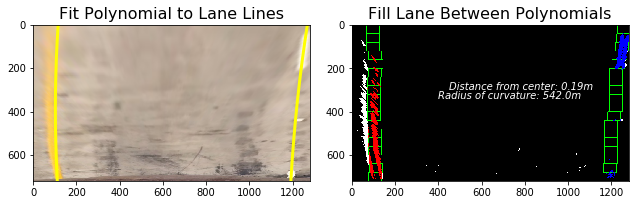

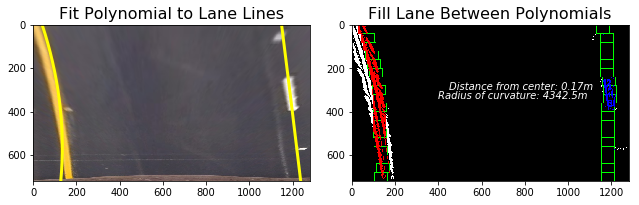

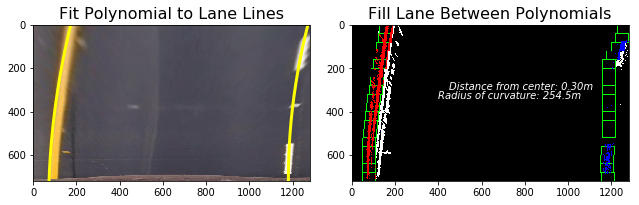

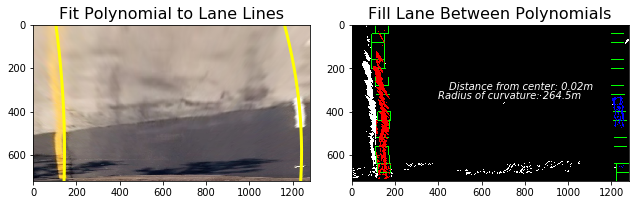

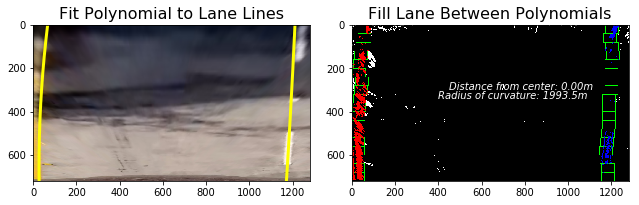

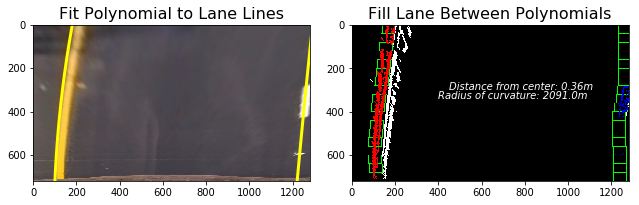

In [16]:
Right = Line()
Left = Line()
for image in glob.glob('test_images/test[1-6].jpg'):
    Right = Line()
    Left = Line()
    image = cv2.imread(image)
    undist_img = undistort(image)
    warped, M = persp_trans(undist_img, nx, ny, show=False)
    combined_binary = detect_line(image, warped)
    fill_lane(combined_binary, show=True)

In [17]:
# Video Processing Pipeline
def process_vid(image, show=False):
    undist = undistort(image)
    warped, M = persp_trans(undist, nx, ny, show=False)
    Minv = np.linalg.inv(M)
    combined_binary = detect_line(image, warped)
    ploty, left_fitx, right_fitx, distance_from_center, curvature = fill_lane(combined_binary)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Print curvature and center offset on an image
    text = 'Curvature: {0:.0f}m, Distance from center: {1:.1f}m'.format(curvature, distance_from_center)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text, (50, 50), font, 1, (200, 255, 155), 2, cv2.LINE_AA)
    
    if show:
        f, ax1 = plt.subplots(1,1,figsize=(9,6))
        f.tight_layout()
        img = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)
        cv2.putText(img, text, (50, 50), font, 1, (200, 255, 155), 2, cv2.LINE_AA)
        ax1.imshow(img)
    return result

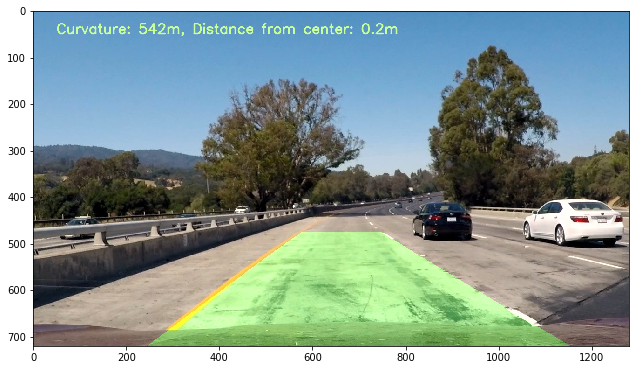

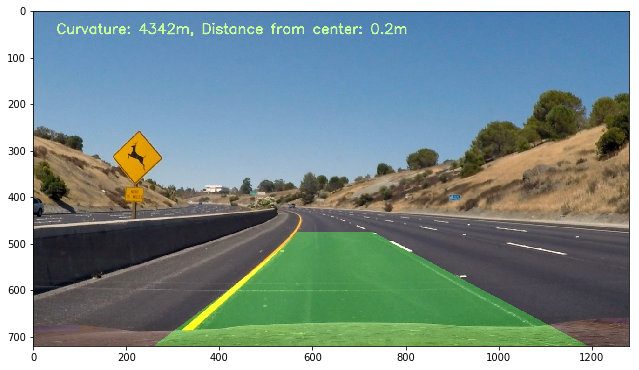

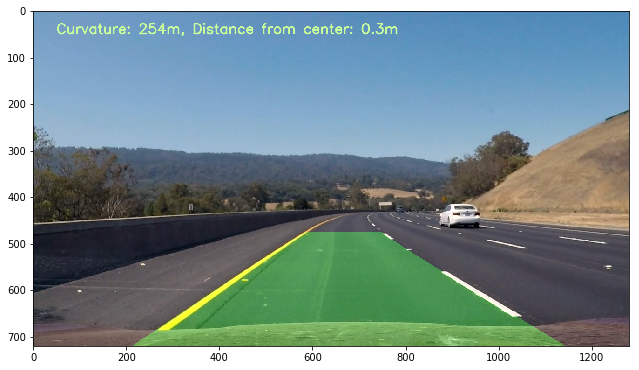

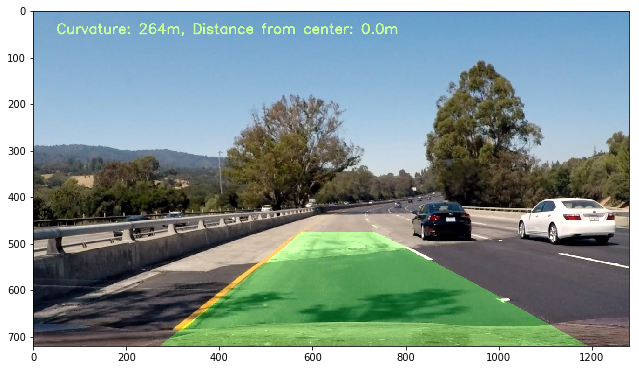

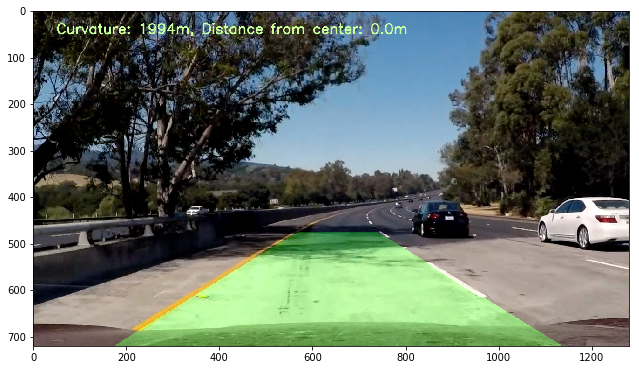

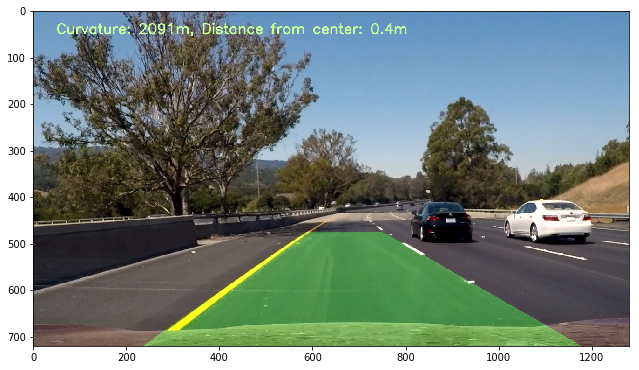

In [18]:
Right = Line()
Left = Line()
for image in glob.glob('test_images/test[1-6].jpg'):
    Right = Line()
    Left = Line()
    image = cv2.imread(image)
    process_vid(image, show=True)

In [19]:
Right = Line()
Left = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(30,45)
white_clip = clip1.fl_image(process_vid)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:03<00:00,  1.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [20]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [25]:
Right = Line()
Left = Line()
video_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(5,10)
white_clip = clip1.fl_image(process_vid)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [07:44<00:00,  1.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



In [26]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))